# Example

TypeError: Image data of dtype object cannot be converted to float

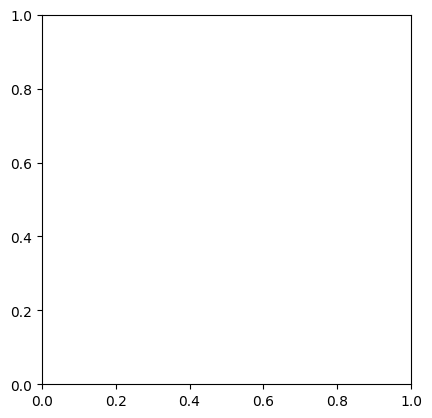

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("CV_HAND_MODEL/images/img2.jpg")
plt.imshow(img)

c:\Users\Ivan\Documents\CMA\ML Parkinsons Repository\Parkinson-Prediagnosis\Exp\CV_Hand_Model\venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


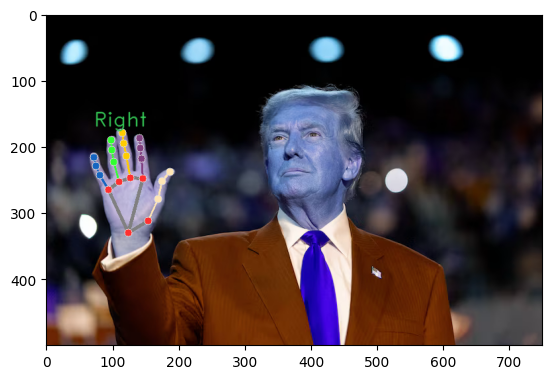

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from utils.draw_landmarks import draw_landmarks_on_image

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
img = cv2.imread("images/img1.png")

# STEP 3.5: Convert to Mediapip with RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(img)

# STEP 5: Process the classification result. In this case, visualize it.
# Function to draw landmarks on the image
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.


annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

plt.imshow(annotated_image)

# Collect landmark values as csv

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
from mediapipe.tasks.python import vision
from utils.draw_landmarks import draw_landmarks_on_image  # Import the function

# Create a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

video_path = "images/pos1.mp4"
cap = cv2.VideoCapture(video_path)

landmarks_data = []

frame_number = 0  # To keep track of frame number
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"Processing Video...")
        break

    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to Mediapipe
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect hand landmarks from the input image
    detection_result = detector.detect(mp_image)

    # Process the classification result
    annotated_frame = draw_landmarks_on_image(frame_rgb, detection_result)
    
    # Extract landmarks
    if detection_result.hand_landmarks:
        for hand_landmarks in detection_result.hand_landmarks:
            for idx, landmark in enumerate(hand_landmarks):
                landmarks_data.append({
                    'Frame': frame_number,
                    'Landmark Index': idx,
                    'X': landmark.x,
                    'Y': landmark.y,
                    'Z': landmark.z
                })

    # Display the annotated frame
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('Hand Landmarks', annotated_frame_bgr)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

# Create DataFrame
df = pd.DataFrame(landmarks_data)
print(df)


c:\Users\Ivan\Documents\CMA\ML Parkinsons Repository\Parkinson-Prediagnosis\Exp\CV_Hand_Model\venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing Video...
      Frame  Landmark Index         X         Y         Z
0         0               0  0.174136  0.626786  0.000001
1         0               1  0.335029  0.783327  0.006569
2         0               2  0.466243  0.786928  0.037071
3         0               3  0.567691  0.775332  0.073035
4         0               4  0.657200  0.757464  0.117574
...     ...             ...       ...       ...       ...
9802    466              16  0.542699  0.266671  0.502300
9803    466              17  0.334570  0.348490  0.300859
9804    466              18  0.373891  0.325049  0.421216
9805    466              19  0.399410  0.329465  0.482979
9806    466              20  0.409189  0.332015  0.528438

[9807 rows x 5 columns]


In [ ]:
df.to_csv('landmarks_pos1.csv', index=False)  # Save DataFrame to CSV

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9807 entries, 0 to 9806
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frame           9807 non-null   int64  
 1   Landmark Index  9807 non-null   int64  
 2   X               9807 non-null   float64
 3   Y               9807 non-null   float64
 4   Z               9807 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 383.2 KB


# Computing Change in Velocity from Generated Video df

In [ ]:
fps = 30
time_per_frame = 1/fps

# Convert values to float
#df['X'] = df['X'].astype(float)
#df['Y'] = df['Y'].astype(float)
#df['Z'] = df['Z'].astype(float)

# Sort the df by landmark index
df = df.sort_values(by=['Frame', 'Landmark Index'])

# Calcualte the displacement by frame of landmark index
df['dX'] = df.groupby('Landmark Index')['X'].diff()
df['dY'] = df.groupby('Landmark Index')['Y'].diff()
df['dZ'] = df.groupby('Landmark Index')['Z'].diff()

# Calculate magnitude of displcemnt in 3d space
df['Velocity'] = np.sqrt(df['dX']**2 + df['dY']**2 + df['dZ']**2)/ time_per_frame

df = df.dropna()

df.head()



,Frame,Landmark Index,X,Y,Z,dX,dY,dZ,Velocity
42,2,0,0.165304,0.617662,0.000001,-0.003461,-0.008324,-1.088231e-07,0.270448
43,2,1,0.325516,0.772077,0.005998,-0.010352,-0.012923,8.213227e-04,0.497368
44,2,2,0.460595,0.783671,0.034256,-0.003133,-0.006738,4.014969e-04,0.223251
45,2,3,0.563972,0.770200,0.066753,0.001656,-0.004328,-2.034105e-03,0.151827
46,2,4,0.650412,0.753122,0.106228,-0.000091,-0.000292,-5.908243e-03,0.177485


<function matplotlib.pyplot.show(close=None, block=None)>

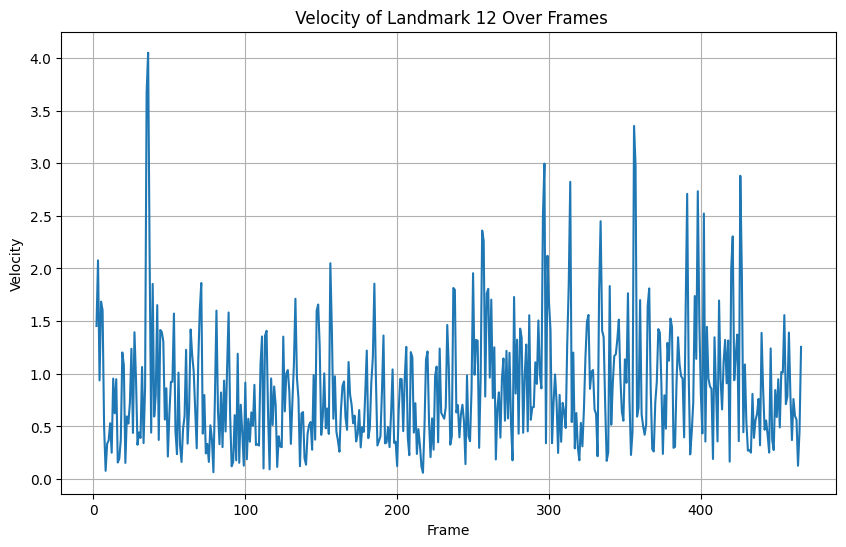

In [ ]:
# BASIC GRAPH
import matplotlib.pyplot as plt

landmark_index = 12

landmark_data = df[df['Landmark Index'] == landmark_index]

plt.figure(figsize=(10,6))
plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label=f'Landmark {landmark_index}')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title(f' Velocity of Landmark {landmark_index} Over Frames')
plt.grid(True)

plt.show

C:\Users\Ivan\AppData\Local\Temp\ipykernel_21768\1091031434.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmark_data['Moving_Average'] = landmark_data['Velocity'].rolling(window=window_size).mean()


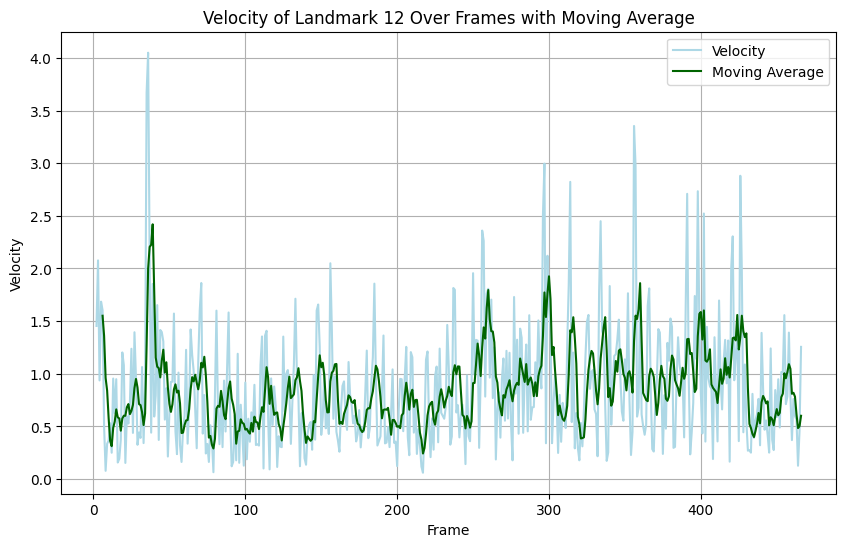

In [ ]:
# GRAPH WITH AVERAGE

def plot_velocity_with_moving_average(df, landmark_index, window_size=5):
    """
    Plots the velocity of a specified landmark over frames with a moving average trendline.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        landmark_index (int): The index of the landmark to plot.
        window_size (int): The size of the moving average window.
    """
    # Filter the DataFrame for the selected landmark
    landmark_data = df[df['Landmark Index'] == landmark_index]

    # Calculate moving average
    landmark_data['Moving_Average'] = landmark_data['Velocity'].rolling(window=window_size).mean()

    # Plot velocity and moving average
    plt.figure(figsize=(10, 6))
    plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label='Velocity', color='lightblue')
    plt.plot(landmark_data['Frame'], landmark_data['Moving_Average'], label='Moving Average', color='darkgreen', linestyle='-')

    # Add labels and title
    plt.xlabel('Frame')
    plt.ylabel('Velocity')
    plt.title(f'Velocity of Landmark {landmark_index} Over Frames with Moving Average')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
plot_velocity_with_moving_average(df, landmark_index=12)  # Replace 0 with your desired landmark index


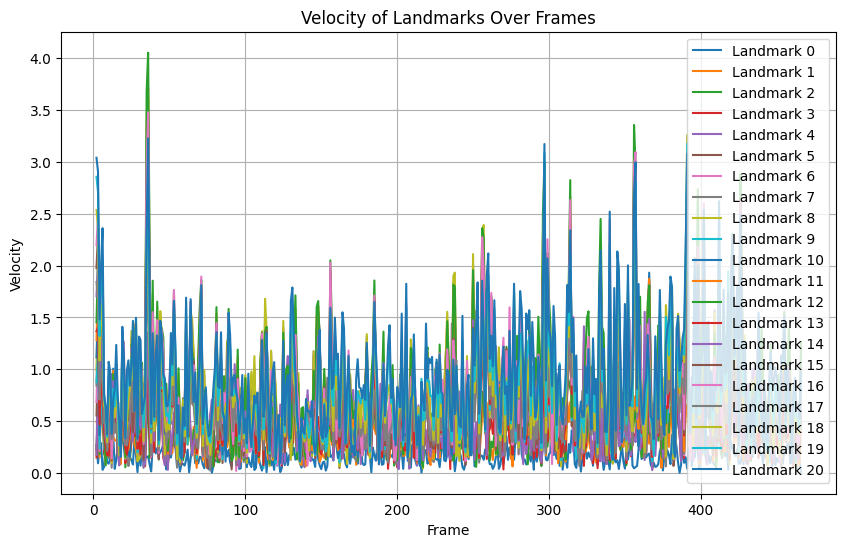

In [ ]:
# ALL LANDMARKS

# Plot velocity for each landmark
plt.figure(figsize=(10, 6))

# Loop through each landmark and plot its velocity
for landmark in df['Landmark Index'].unique():
    landmark_data = df[df['Landmark Index'] == landmark]
    plt.plot(landmark_data['Frame'], landmark_data['Velocity'], label=f'Landmark {landmark}')

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Velocity of Landmarks Over Frames')
plt.legend()  # Add a legend to differentiate between landmarks
plt.grid(True)

# Show the plot
plt.show()
